In [1194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve
from imblearn.over_sampling import SMOTE
pd.pandas.set_option('display.max_columns', None)

In [1195]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [1196]:
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (5092, 7)
Test shape: (2546, 6)


In [1197]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5092 entries, 0 to 5091
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         5092 non-null   int64  
 1   obs_count  5092 non-null   int64  
 2   std        5092 non-null   float64
 3   median     5092 non-null   float64
 4   mean       5092 non-null   float64
 5   skew       5092 non-null   float64
 6   y          5092 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 278.6 KB


In [1198]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2546 entries, 0 to 2545
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         2546 non-null   int64  
 1   obs_count  2546 non-null   int64  
 2   std        2546 non-null   float64
 3   median     2546 non-null   float64
 4   mean       2546 non-null   float64
 5   skew       2546 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 119.5 KB


In [1199]:
train.head()

,id,obs_count,std,median,mean,skew,y
0,1,4360,5.469419,4.0,5.940054,1.844145,0
1,2,817,7.860077,5.0,7.564815,1.543974,0
2,3,845,12.973234,2.0,5.348101,8.244160,0
3,4,816,4.343777,2.0,2.804124,9.467990,0
4,5,283,5.581529,4.0,5.442308,2.448486,0


In [1200]:
train['obs_count'] = np.log1p(train['obs_count'])
test['obs_count'] = np.log1p(test['obs_count'])

train['std'] = np.log1p(train['std'])
test['std'] = np.log1p(test['std'])


train['mean'] = np.log1p(train['mean'])
test['mean'] = np.log1p(test['mean'])

train['skew'] = np.log1p(train['skew'])
test['skew'] = np.log1p(test['skew'])

<AxesSubplot:xlabel='std', ylabel='Count'>

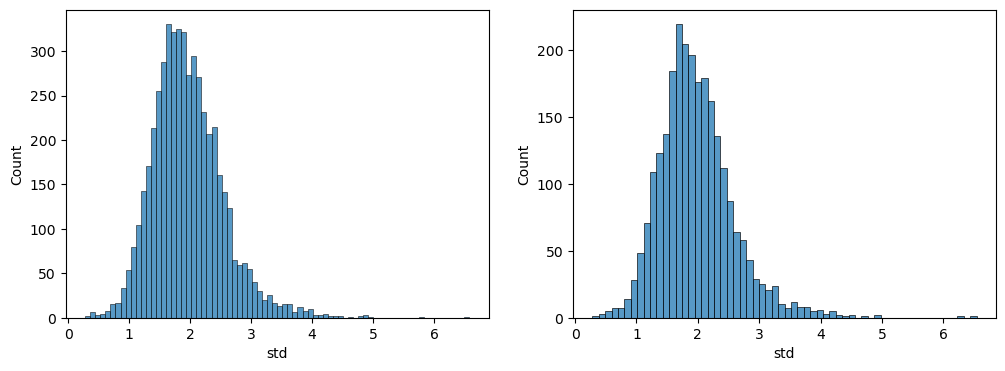

In [1202]:
fig, ax = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (16,16)
sns.histplot(x=train['std'], ax=ax[0])
sns.histplot(x=test['std'], ax=ax[1])

<AxesSubplot:xlabel='obs_count', ylabel='Count'>

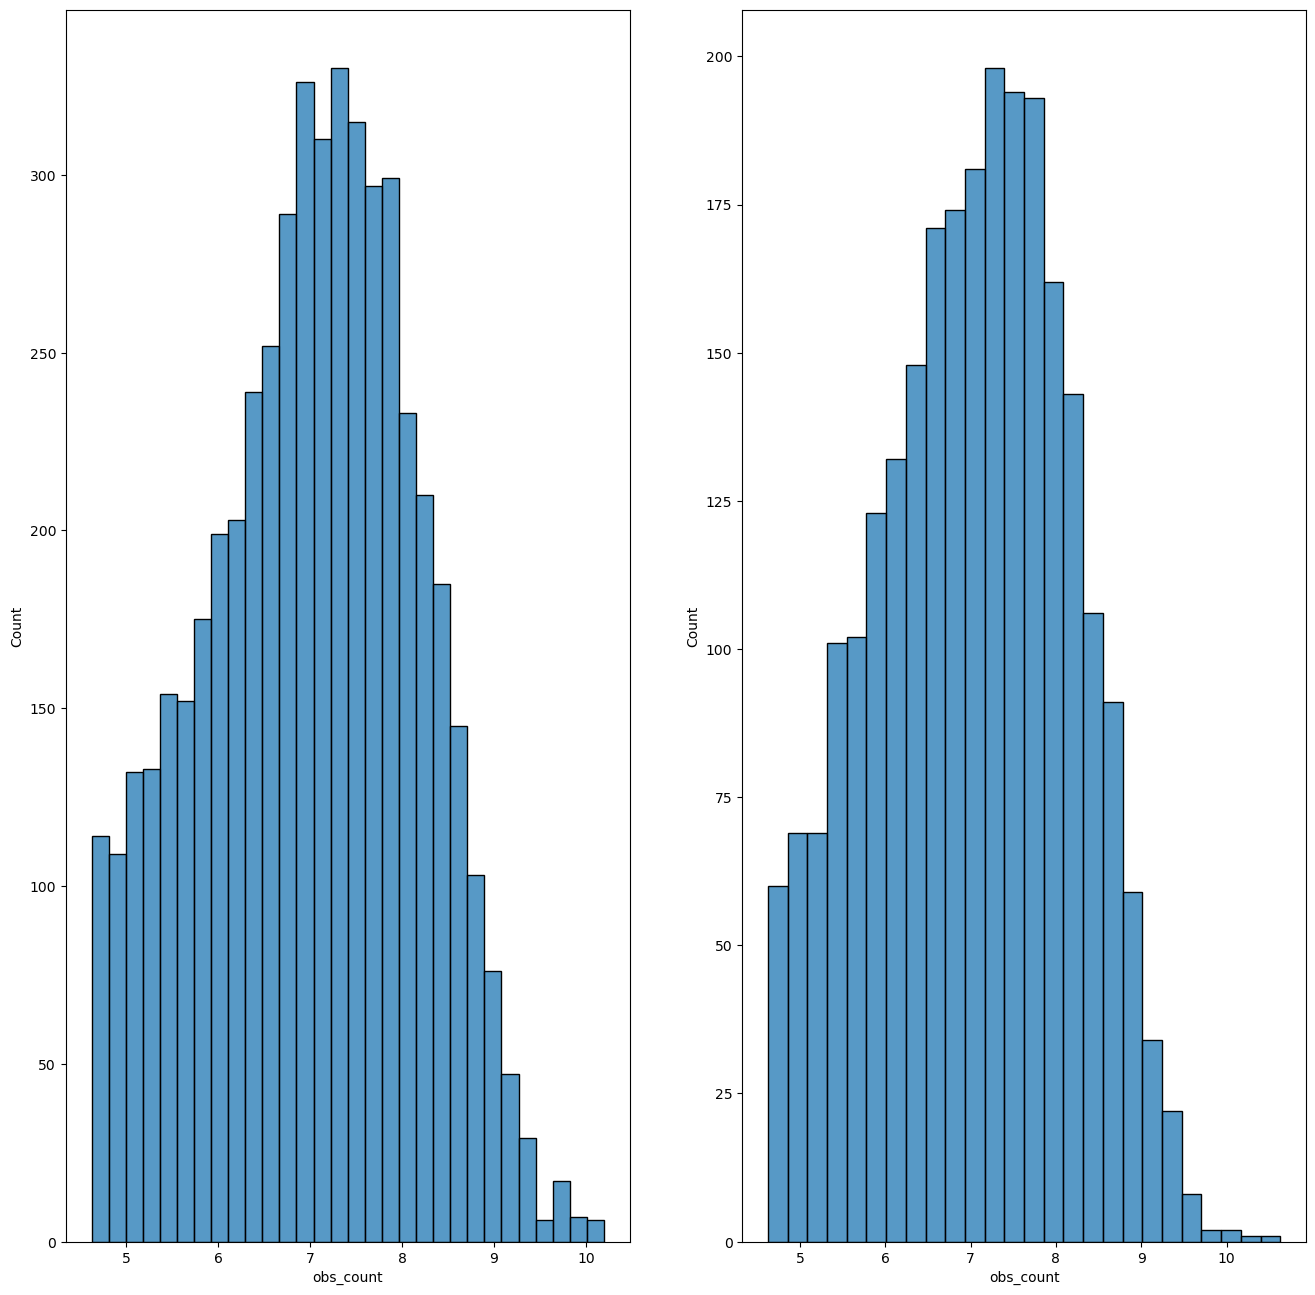

In [1203]:
fig, ax = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (16,16)
sns.histplot(x=train['obs_count'], ax=ax[0])
sns.histplot(x=test['obs_count'], ax=ax[1])

<AxesSubplot:ylabel='obs_count'>

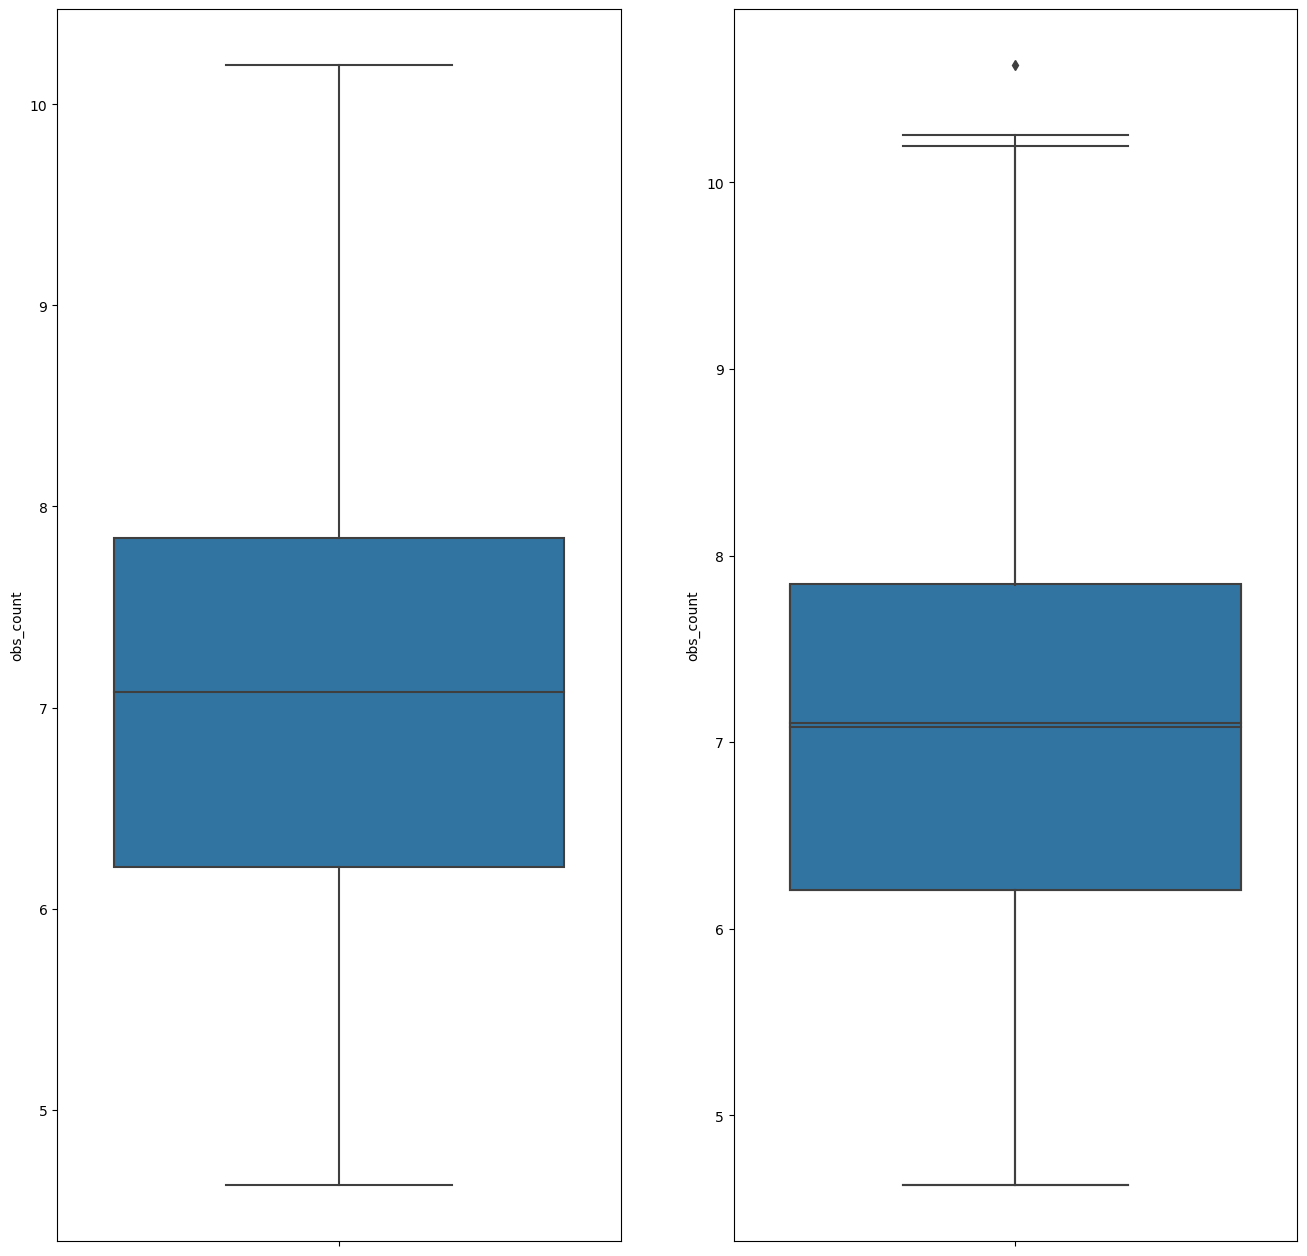

In [1204]:
fig, ax = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (12,4)
sns.boxplot(y=train['obs_count'])
sns.boxplot(y=train['obs_count'], ax=ax[0])
sns.boxplot(y=test['obs_count'], ax=ax[1])

In [1205]:
train.head()

,id,obs_count,std,mean,skew,y
0,1,8.380457,1.867086,5.940054,1.844145,0
1,2,6.706862,2.181555,7.564815,1.543974,0
2,3,6.740519,2.637144,5.348101,8.244160,0
3,4,6.705639,1.675933,2.804124,9.467990,0
4,5,5.648974,1.884267,5.442308,2.448486,0


<AxesSubplot:ylabel='std'>

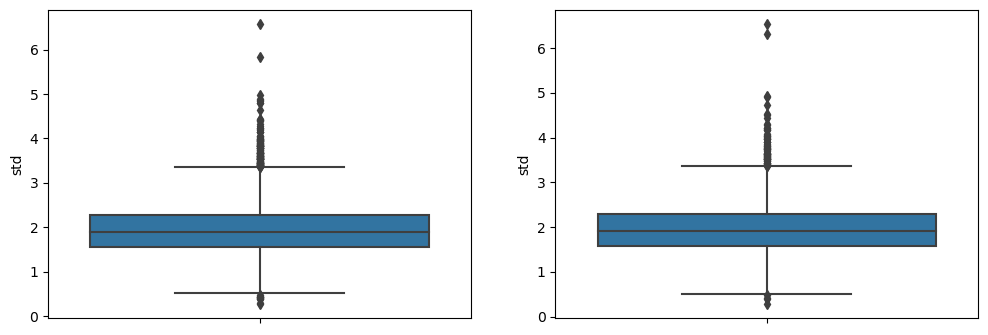

In [1206]:
fig, ax = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (12,4)
sns.boxplot(y=train['std'], ax=ax[0])
sns.boxplot(y=test['std'], ax=ax[1])

In [1207]:
Q1 = np.quantile(train['obs_count'],0.25)
Q3 = np.quantile(train['obs_count'],0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
print(f"lower: {lower}")
print(f'upper: {upper}')

lower: 3.759530605772454
upper: 10.290355726636921


In [1208]:
train[train['obs_count']>=upper].count()

id           0
obs_count    0
std          0
mean         0
skew         0
y            0
dtype: int64

In [1209]:
train = train[train['obs_count']<=upper]

In [1210]:
def categorizer(num):
    if num in range(1000):
        return "0-999"
    if num in range(1000,2000):
        return "1000-1999"
    if num in range(2000,3000):
        return "2000-2999"
    if num in range(3000,4000):
        return "3000-3999"
    if num in range(4000,5000):
        return "4000-4999"
    else:
        return "5000+"

In [1211]:
train['obs_range'] = train['obs_count'].apply(categorizer)
test['obs_range'] = test['obs_count'].apply(categorizer)

In [1212]:
onehot = pd.get_dummies(train['obs_range'])
onehot_test = pd.get_dummies(test['obs_range'])

In [1213]:
train = pd.concat([train, onehot], axis=1)
test = pd.concat([test, onehot_test], axis=1)

In [1214]:
train = train.drop(['obs_count', 'obs_range'], axis=1)
test = test.drop(['obs_count', 'obs_range'], axis=1)

In [1216]:
train.head(5)

,id,std,mean,skew,y,5000+
0,1,1.867086,5.940054,1.844145,0,1
1,2,2.181555,7.564815,1.543974,0,1
2,3,2.637144,5.348101,8.244160,0,1
3,4,1.675933,2.804124,9.467990,0,1
4,5,1.884267,5.442308,2.448486,0,1


In [1217]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5092 entries, 0 to 5091
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      5092 non-null   int64  
 1   std     5092 non-null   float64
 2   mean    5092 non-null   float64
 3   skew    5092 non-null   float64
 4   y       5092 non-null   int64  
 5   5000+   5092 non-null   uint8  
dtypes: float64(3), int64(2), uint8(1)
memory usage: 243.7 KB


## Scaling

In [1218]:
X = train.drop('y', axis=1)
y = train['y']

In [1219]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(test)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=test.columns, index=test.index)

## Upsampling (worked worse somewhat)

In [1220]:
# sm = SMOTE(random_state=2)

# X, y = sm.fit_resample(X, y.ravel())

# print('After OverSampling, the shape of X: {}'.format(X.shape))
# print('After OverSampling, the shape of y: {} \n'.format(y.shape))

# print("After OverSampling, counts of label '1': {}".format(sum(y==1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y==0)))

In [1221]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8)


In [1222]:
train['y'].value_counts()

0    4993
1      99
Name: y, dtype: int64

In [1223]:
weight = train['y'][train['y']==0].count()/train['y'][train['y']==1].count()
weight

50.43434343434343

In [1224]:
model = CatBoostClassifier(
    eval_metric="AUC",
    scale_pos_weight= weight,
    early_stopping_rounds=20
)

In [1225]:
model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.044829
0:	test: 0.8678315	best: 0.8678315 (0)	total: 2.74ms	remaining: 2.74s
1:	test: 0.8921853	best: 0.8921853 (1)	total: 3.88ms	remaining: 1.94s
2:	test: 0.8834684	best: 0.8921853 (1)	total: 5.25ms	remaining: 1.75s
3:	test: 0.8812127	best: 0.8921853 (1)	total: 6.45ms	remaining: 1.6s
4:	test: 0.8841566	best: 0.8921853 (1)	total: 7.61ms	remaining: 1.51s
5:	test: 0.8861829	best: 0.8921853 (1)	total: 8.71ms	remaining: 1.44s
6:	test: 0.8867182	best: 0.8921853 (1)	total: 9.79ms	remaining: 1.39s
7:	test: 0.8886298	best: 0.8921853 (1)	total: 11.2ms	remaining: 1.38s
8:	test: 0.8909619	best: 0.8921853 (1)	total: 12.5ms	remaining: 1.37s
9:	test: 0.8927588	best: 0.8927588 (9)	total: 13.8ms	remaining: 1.36s
10:	test: 0.8908472	best: 0.8927588 (9)	total: 15ms	remaining: 1.35s
11:	test: 0.8874446	best: 0.8927588 (9)	total: 16.3ms	remaining: 1.34s
12:	test: 0.8862594	best: 0.8927588 (9)	total: 17.5ms	remaining: 1.33s
13:	test: 0.8850359	best: 0.8927588 (9)	total: 18.8ms	remain

Grid search worked worse

In [1226]:
# param_grid = {'scale_pos_weight': [x/2 for x in range(140, 181)]}

# clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=20)

# grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc')

# grid_search.fit(X_train, y_train)

# print("Best parameter: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)


# best_model = grid_search.best_estimator_

In [1227]:
y_pred = model.predict(X_val)
print(roc_auc_score(y_val, y_pred))
y_proba = model.predict_proba(test)

0.897117296222664


In [1228]:
# y_pred2 = best_model.predict(X_val)
# print(roc_auc_score(y_val, y_pred2))
# y_proba2 = best_model.predict_proba(test)

In [1229]:
pos_proba=y_proba[:,1]
# pos_proba2=y_proba[:,1]

In [1230]:
y_pred = model.predict(test)

In [1231]:
len(y_pred)

2546

In [1232]:
submission_df = pd.DataFrame({'id': test['id'], 'y': y_pred})
submission_df.to_csv("1_at.csv", index=False)
submission_df = pd.DataFrame({'id': test['id'], 'y': pos_proba})
submission_df.to_csv("proba.csv", index=False)
# submission_df = pd.DataFrame({'id': test['id'], 'y': pos_proba2})
# submission_df.to_csv("proba2.csv", index=False)